In [1]:
"""!git clone https://github.com/XifengGuo/CapsNet-Keras
import os
os.chdir('CapsNet-Keras')"""

"!git clone https://github.com/XifengGuo/CapsNet-Keras\nimport os\nos.chdir('CapsNet-Keras')"

In [1]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
import matplotlib.pyplot as plt
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask

K.set_image_data_format('channels_last')


Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 16s 1us/step


In [13]:
x_train = np.vstack([x_train,x_test])
y_train = np.concatenate([y_train,y_test])

In [14]:
y_train.shape

(70000,)

In [3]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


In [4]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [5]:
def test(model, data, args):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    print()
    print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    plt.show()

In [6]:
def manipulate_latent(model, data, args):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == args.digit
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)

In [7]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

In [9]:
# load data
(x_train, y_train), (x_test, y_test) = load_mnist()

    # define model
model, eval_model, manipulate_model = CapsNet(input_shape=x_train.shape[1:],
                                                  n_class=len(np.unique(np.argmax(y_train, 1))),
                                                  routings=3)
model.summary()

11501568/11490434 [==============================] - 22s 2us/step
Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_con

In [33]:
eval_model.load_weights('trained_model-11-19.h5')

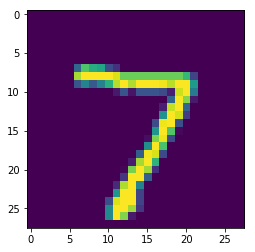

In [34]:
plt.imshow(x_test[0].reshape(28,28))

In [35]:
def manipulate_latent(model, data):
    print('-'*30 + 'Begin: manipulate' + '-'*30)
    x_test, y_test = data
    index = np.argmax(y_test, 1) == 5
    number = np.random.randint(low=0, high=sum(index) - 1)
    x, y = x_test[index][number], y_test[index][number]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, 10, 16])
    x_recons = []
    for dim in range(16):
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)

    img = combine_images(x_recons, height=16)
    image = img*255
    #Image.fromarray(image.astype(np.uint8)).save(args.save_dir + '/manipulate-%d.png' % args.digit)
    #print('manipulated result saved to %s/manipulate-%d.png' % (args.save_dir, args.digit))
    print('-' * 30 + 'End: manipulate' + '-' * 30)



In [36]:
manipulate_latent(manipulate_model, (x_test, y_test))

------------------------------Begin: manipulate------------------------------
------------------------------End: manipulate------------------------------


In [37]:
x_test[0].shape

(28, 28, 1)

In [38]:
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict(x_test, batch_size=100)
    print('-'*30 + 'Begin: test' + '-'*30)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    #Image.fromarray(image.astype(np.uint8)).save(args.save_dir + "/real_and_recon.png")
    #print()
    #print('Reconstructed images are saved to %s/real_and_recon.png' % args.save_dir)
    print('-' * 30 + 'End: test' + '-' * 30)
    #plt.imshow(plt.imread(args.save_dir + "/real_and_recon.png"))
    #plt.show()

In [39]:
pred=eval_model.predict(x_test[0].reshape(1,28,28,1))
np.argmax(pred[0])

7

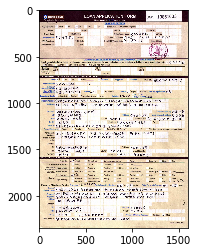

In [40]:
import cv2
sample_path='application_form-0b2b3916-361-1.jpg'
img=cv2.imread(sample_path)
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
size=(1700,2338)
thresh = cv2.resize(img, size, interpolation = cv2.INTER_AREA)

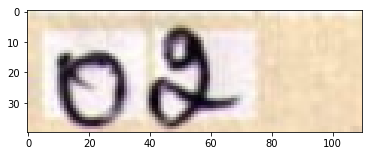

In [41]:
cropped_applicationdate = thresh[535:585, 1450:1685]
cropped_pan = thresh[725:775, 1235:1685]
cropped_Applicant_Name = thresh[765:815, 170:1685]
cropped_fathersname = thresh[810:862, 170:1480]
cropped_dateofbirth = thresh[855:905, 180:500]
cropped_noofdependents = thresh[855:895, 1440:1550]
#cv2.imshow("cropped", cropped_applicationdate)
#cv2.waitKey(5000)
#cv2.destroyAllWindows()
plt.imshow(cropped_noofdependents)

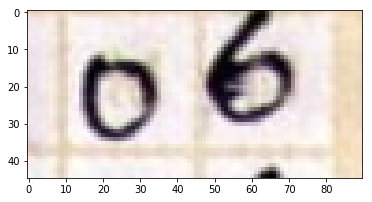

In [42]:
cropped_current_address_line1 = thresh[950:1000, 170:1480]
cropped_current_address_line2 = thresh[990:1035, 170:1480]
cropped_current_address_line3 = thresh[1028:1072, 170:1480]
cropped_current_address_landmark = thresh[1070:1115, 170:1300]
cropped_current_address_city = thresh[1112:1155, 170:930]
cropped_current_address_state = thresh[1145:1190, 170:705]
cropped_current_address_country = thresh[1140:1190, 770:1075]
cropped_current_address_pincode = thresh[1112:1155, 1040:1255]
cropped_aadhar = thresh[1140:1190, 1214:1671]
cropped_current_telephone = thresh[1180:1225, 170:770]
cropped_current_mobilephone = thresh[1180:1225, 910:1300]
cropped_emailid = thresh[1220:1270, 170:1671]
cropped_yearsatcurrentcity = thresh[1070:1115, 1580:1670]
cropped_yearsatcurrentresidence = thresh[1110:1155, 1585:1670]
#cv2.imshow("cropped", cropped_current_address_line1)
#cv2.waitKey(5000)
#cv2.destroyAllWindows()
plt.imshow(cropped_yearsatcurrentcity)

In [43]:
cropped_permanent_address_pincode = thresh[1451:1500, 1000:1250]
cropped_permanent_address_line1 = thresh[1300:1345, 170:1480]
cropped_permanent_address_line2 = thresh[1345:1380, 170:1480]
cropped_permanent_address_line3 = thresh[1375:1415, 170:1480]
cropped_permanent_address_landmark = thresh[1412:1455, 170:1300]
cropped_permanent_address_city = thresh[1452:1495, 170:930]
cropped_permanent_address_state = thresh[1495:1535, 170:705]
cropped_permanent_address_country = thresh[1490:1535, 770:1075]
cropped_voterid = thresh[1490:1535, 1205:1670]
cropped_permanent_telephone = thresh[1527:1575, 170:770]
cropped_permanent_mobilephone = thresh[1527:1575, 860:1300]

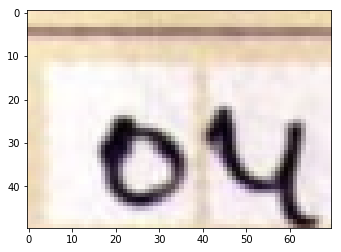

In [44]:
#employer details
cropped_EmployerName = thresh[1900:1955, 170:1480]
cropped_EmployerAddress_line1 = thresh[1940:1990, 170:1480]
cropped_EmployerAddress_line2 = thresh[1985:2030, 170:1480]
cropped_EmployerAddress_line3 = thresh[2020:2065, 170:1480]
cropped_EmployerAddress_landmark = thresh[2050:2100, 170:1480]
cropped_EmployerAddress_city = thresh[2095:2140, 170:950]
cropped_EmployerAddress_pincode = thresh[2095:2140, 1000:1480]
cropped_EmployerAddress_state = thresh[2132:2180, 170:950]
cropped_EmployerAddress_country = thresh[2132:2180, 1000:1670]
cropped_EmployerAddress_telephone = thresh[2175:2220, 170:1000]
cropped_EmployerAddress_official_emailID = thresh[2220:2260, 170:1671]
cropped_EmployerAddress_currentexperience = thresh[1850:1900, 880:960]
cropped_EmployerAddress_Totalexperience = thresh[1850:1900, 1400:1470]
plt.imshow(cropped_EmployerAddress_Totalexperience)


In [45]:
from PIL import Image
import sys
#import pytesseract
import cv2
import numpy as np
#import pytesseract
import matplotlib.pyplot as plt
import math

In [46]:
def preprocess(image):
  
  size=(400,400)

  TARGET_PIXEL_AREA = 350000.0

  ratio = float(image.shape[1]) / float(image.shape[0])
  new_h = int(math.sqrt(TARGET_PIXEL_AREA / ratio) + 0.5)
  new_w = int((new_h * ratio) + 0.5)
  image_resized = cv2.resize(image, (new_w,new_h))
#plt.imshow(cropped_dateofbirth_resized)
# noise removal
  gray = cv2.cvtColor(image_resized,cv2.COLOR_BGR2GRAY)
  ret, thresh1 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#plt.imshow(thresh1)
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh1,cv2.MORPH_OPEN,kernel, iterations = 2)

  im2, contours, hierarchy = cv2.findContours(opening,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  #img_contour=cv2.drawContours(image_resized.copy(), contours, -1, (0,255,0), 3)
  return(contours, opening)

#plt.imshow(img_contour)
#plt.show()
#print(len(contours))

In [47]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
 
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
 
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
 
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
 
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [228]:
def prediction(contours,opening):
    (cnts, boundingBoxes) = sort_contours(contours)
    threshold_area=400 #Change it accordingly.

    dob=""
    for cnt in cnts:
        area = cv2.contourArea(cnt)         
        if area > threshold_area:    
            x,y,w,h = cv2.boundingRect(cnt)
            img2 = opening[y:y+h, x:x+w]

            #img3 = Image.fromarray(img2)
            #img3 = cv2.bilateralFilter(img2, 11, 17, 17)
            #edges = cv2.Canny(img3,100,300,apertureSize = 3)
            size = (28,28)
            #img3 = imresize(img2, size)
            img3 = cv2.resize(img2, size)
            #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
            #threshyou = cv2.dilate(img3,kernel,iterations = 3)
            #threshblur = cv2.bilateralFilter(threshyou, 11, 17, 17)
            # = cv2.convexHull(cnt)
            (thresh, im_bw) = cv2.threshold(img3, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            img4 = im_bw.reshape(1,28,28,1)
            percentage =float((np.sum(img4 == 255))/784.0)            
            if percentage >0.20 and percentage <0.70:
                print (percentage)
                plt.imshow(img3,cmap='gray')
                plt.show()
                prediction1=""
                #prediction1=  model.predict(img3.reshape(1,28,28,1))#pytesseract.image_to_string(img2,   config="-c tessedit_char_whitelist=0123456789")

                #prediction1 = model.predict([img3.reshape(1,28,28,1), np.zeros((data_test.shape[0],10))]
                prediction1,prediction2= eval_model.predict(img4,
                                    # empty values for the second vector 
                                   batch_size = 32, verbose = True)
                test = np.argmax(prediction1,1)
                prediction_final = test[0]
                dob+=str(prediction_final)



                #print (prediction1)
                #plt.imshow(img3)
                #plt.show()
    return (dob)

In [229]:
dobcountours, dobopening = preprocess(cropped_dateofbirth)
appdatecontours, appdateopening = preprocess(cropped_applicationdate)
pancontours, panopening   = preprocess(cropped_pan)
dependentscontours, dependentsopening = preprocess(cropped_noofdependents)
pincodecontours, pincodeopeing = preprocess(cropped_current_address_pincode)
aadharcontours, aadharopening = preprocess(cropped_aadhar)
mobilecontours, mobileopening = preprocess(cropped_current_mobilephone)
yearsatcurrentcitycontours, yearsatcurrentcityopening =  preprocess(cropped_yearsatcurrentcity)
yearsatcurrentresidencecontours, yearsatcurrentresidenceopening =   preprocess(cropped_yearsatcurrentresidence)
currentexperiencecontours, currentexperienceopening = preprocess(cropped_EmployerAddress_currentexperience)
totalexperiencecontours, totalexpereienceopening  = preprocess(cropped_EmployerAddress_Totalexperience)

0.530612244898


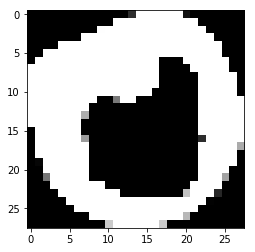

1/1 [==============================] - 0s 27ms/step
0.478316326531


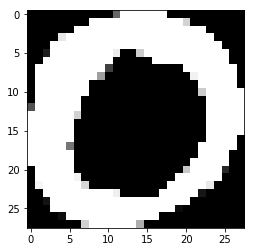

1/1 [==============================] - 0s 36ms/step
('dob is ', '00')


In [245]:
dobpredicted = prediction(currentexperiencecontours, currentexperienceopening)
print("dob is ",dobpredicted)

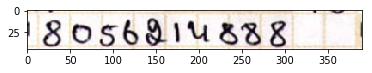

In [241]:
plt.imshow(cropped_current_mobilephone)

True

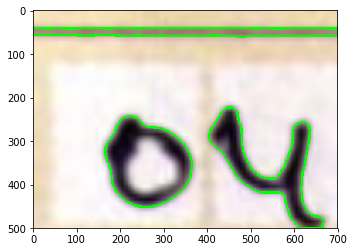

In [96]:
image=cropped_EmployerAddress_Totalexperience
size=(400,400)

TARGET_PIXEL_AREA = 350000.0

ratio = float(image.shape[1]) / float(image.shape[0])
new_h = int(math.sqrt(TARGET_PIXEL_AREA / ratio) + 0.5)
new_w = int((new_h * ratio) + 0.5)
imgawe = cv2.resize(image, (new_w,new_h))

img_contour=cv2.drawContours(imgawe.copy(), totalexperiencecontours, -1, (0,255,0), 3)
plt.imshow(img_contour)
cv2.imwrite('d.jpg',img_contour)

In [102]:
for c in totalexperiencecontours :
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    print not len(approx) == 4

True
True
True


In [118]:
np.unique(img4)

NameError: name 'img4' is not defined